In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision 
from torchvision import transforms as T
from torchvision.datasets import CIFAR10, SVHN
import torch.nn.functional as F
from torch import optim

import os
import sys
from numpy.random import choice as npc
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import wandb

from siamese_dataloader import CIFAR10_TrainValPair_OE, CIFAR10_TrainPair, CIFAR10_ValPair
from siamese_resnet import BasicBlock, Siamese_ResNet
from useful_fc import show_dist, show_auroc

### Prepare dataset

In [2]:
# load cifar10 dataset
transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),])
# CIFAR10 - train
cifar10_dataset = CIFAR10(root="./data", train=True, transform=transform, download = False)  
torch.manual_seed(2021)
cifar10_dataset_train, cifar10_dataset_val = torch.utils.data.random_split(cifar10_dataset, [40000, 10000])
# CIFAR10 - test
cifar10_dataset_test = CIFAR10(root="./data", train=False, transform=transform, download =False)
# SVHN
svhn_dataset = SVHN(root="./data", split = 'train', transform=transform, download = False) 
# TinyImageNet
tinyimagenet_dataset = torchvision.datasets.ImageFolder("./data/Imagenet_resize", transform=transform)
# LSUN
lsun_dataset = torchvision.datasets.ImageFolder("./data/LSUN_resize", transform=transform)

In [4]:
trainset_oe = CIFAR10_TrainValPair_OE(cifar10_dataset_train, 
                                      svhn_dataset, 
                                      size = 40000, 
                                      seen_classes = [4,5,6,7,8,9], #list(range(6)),
                                      oe_classes = list(range(5)))  #[5,6,7,8,9])  #list(range(5)))
valset_oe = CIFAR10_TrainValPair_OE(cifar10_dataset_val, 
                                 svhn_dataset,
                                 size = 10000, 
                                 seen_classes = [4,5,6,7,8,9], #list(range(6)), 
                                 oe_classes = list(range(5,10)))  #list(range(5))) #list(range(5,10)))
#valset_oe = CIFAR10_ValPair(cifar10_dataset_val, 
#                         val_size = 10000, 
#                         seen_classes = list(range(6)), 
#                         ood_classes = [6,7])

In [5]:
train_dataloader = DataLoader(
            trainset_oe,
            shuffle = True,   
            batch_size=512,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )
val_dataloader = DataLoader(
            valset_oe,
            shuffle = True,    
            batch_size=512,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )

### Training

In [6]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=10):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distance, is_diff):
        loss = torch.mean((1-is_diff) * torch.pow(distance, 2) +                           #same class
               is_diff * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))       #different classes

        return loss

In [7]:
wandb.login()

wandb: Currently logged in as: zoey7407 (use `wandb login --relogin` to force relogin)


True

In [8]:
def train():
    wandb.init(name='Siamese with OE - rotation2', 
               project='training-siamese',
               config={"model": 'resnet18',
                       "resnet_layers": [2,2,2,2],
                       "loss_margin": 17,
                       "learning_rate": 0.001,
                       "weight_decay": 0.0006,
                       "max_epoch": 10,   #1000
                       "early_stop_patience": 20,
                       "early_stop_by_auroc": True,
                       "show_dist_every": 10,
                       "seed": 2021})

    model = Siamese_ResNet(BasicBlock, wandb.config.resnet_layers).cuda()
    model.load_state_dict(torch.load("./stat_dict/siamese_without_oe_best_rotation.pth"))
    
    criterion = ContrastiveLoss(margin = wandb.config.loss_margin)
    optimizer = optim.Adam(model.parameters(),lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)


    num_epochs = wandb.config.max_epoch
    early_stop_counter = 0
    early_stop_patience = wandb.config.early_stop_patience
    early_stop = False
    best_val_loss = 9999
    best_val_auroc_ood = 0
    show_dist_every = wandb.config.show_dist_every

    torch.manual_seed(wandb.config.seed)
    wandb.watch(model)

    for epoch in range(0,num_epochs):
        #train
        model.train()
        train_loss = 0
        for i, tr_batch in enumerate(train_dataloader,0):
            tr_img1, tr_img2, tr_class_1, tr_class_2, tr_is_diff, tr_is_ood = tr_batch
            tr_img1, tr_img2 , tr_is_diff = tr_img1.cuda(), tr_img2.cuda() , tr_is_diff.cuda()
            optimizer.zero_grad()
            _,_, tr_dist = model(tr_img1,tr_img2)
            tr_loss = criterion(tr_dist,tr_is_diff)
            tr_loss.backward()
            optimizer.step()
            train_loss += tr_loss.item()   

        train_loss = train_loss/len(train_dataloader)   # mean epoch loss


        #validation
        model.eval()
        val_loss = 0
        val_is_diff_all = []
        val_is_ood_all = []
        val_dist_all = []
        for j, val_batch in enumerate(val_dataloader,0):
            val_img1, val_img2 , val_class_1, val_class_2, val_is_diff, val_is_ood = val_batch
            val_img1, val_img2 , val_is_diff = val_img1.cuda(), val_img2.cuda() , val_is_diff.cuda()
            _,_,val_dist = model(val_img1,val_img2)
            val_batch_loss = criterion(val_dist,val_is_diff)
            val_loss += val_batch_loss.item()
            val_is_diff_all += val_is_diff.cpu().detach().numpy().squeeze().tolist()
            val_is_ood_all += val_is_ood.cpu().detach().numpy().squeeze().tolist()
            val_dist_all += val_dist.cpu().detach().numpy().squeeze().tolist()

        val_loss = val_loss/len(val_dataloader)
        val_auroc_diff = show_auroc(val_is_diff_all, val_dist_all, display = False)
        val_auroc_ood = show_auroc(val_is_ood_all, val_dist_all, display = False)


        print("\nEpoch {}, Train loss {}, Val loss {}\nVal auroc diff {}, Val auroc ood {}"
                .format(epoch, train_loss, val_loss, val_auroc_diff, val_auroc_ood))

        # display the distance distribution in last training and validation batch
        if epoch % show_dist_every ==0:
            tr_mean_same_dist, tr_mean_diff_seen_dist, tr_mean_diff_ood_dist, val_mean_same_dist, val_mean_diff_seen_dist, val_mean_diff_ood_dist = show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood, plot = True) 
        else:
            tr_mean_same_dist, tr_mean_diff_seen_dist, tr_mean_diff_ood_dist, val_mean_same_dist, val_mean_diff_seen_dist, val_mean_diff_ood_dist = show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood, plot = False) 

        wandb.log({
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Val Loss": val_loss, 
            "Val auroc diff": val_auroc_diff, 
            "Val auroc ood": val_auroc_ood,
            "Train mean distance (same)": tr_mean_same_dist,
            "Train mean distance (diff_seen)": tr_mean_diff_seen_dist,
            "Train mean distance (diff_ood)": tr_mean_diff_ood_dist,
            "Val mean distance (same)": val_mean_same_dist,
            "Val mean distance (diff_seen)": val_mean_diff_seen_dist,
            "Val mean distance (diff_ood)": val_mean_diff_ood_dist
            })

        # early stop by loss
        if wandb.config.early_stop_by_auroc == False:
            if val_loss > best_val_loss:
                early_stop_counter += 1
                print(f'EarlyStopping counter: {early_stop_counter} out of {early_stop_patience}, best val loss: {best_val_loss}')
                if early_stop_counter >= early_stop_patience:
                    early_stop = True
            else:
                best_val_loss = val_loss
                early_stop_counter = 0            
        # early stop by validation ood auroc
        else:
            if val_auroc_ood < best_val_auroc_ood:
                early_stop_counter += 1
                print(f'EarlyStopping counter: {early_stop_counter} out of {early_stop_patience}, best val auroc ood: {best_val_auroc_ood}')
                if early_stop_counter >= early_stop_patience:
                    early_stop = True
            else:
                best_val_auroc_ood = val_auroc_ood
                early_stop_counter = 0

        if early_stop:
            print("Early stopping")
            torch.save(model.state_dict(), "./stat_dict/siamese_with_oe_continue.pth")
            break

    wandb.finish()
    
    tr_mean_same_dist, tr_mean_diff_seen_dist, tr_mean_diff_ood_dist, val_mean_same_dist, val_mean_diff_seen_dist, val_mean_diff_ood_dist = show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood, plot = True) 
    show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood) 
    # auroc for val_is_diff
    show_auroc(val_is_diff.cpu().detach().numpy().squeeze(), val_dist.cpu().detach().numpy().squeeze())
    # auroc for val_is_ood
    show_auroc(val_is_ood.cpu().detach().numpy().squeeze(), val_dist.cpu().detach().numpy().squeeze())
    
    return model

wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 2.0695694562086127, Val loss 20.29113046746505
Val auroc diff 0.8675511433657633, Val auroc ood 0.6658627920944584
Distance distribution of last training batch:
mean_same = 0.6759837865829468, mean_diff_seen = 13.043368339538574, mean_diff_ood = 9.74914264678955
Distance distribution of last validation batch:
mean_same = 3.7567381858825684, mean_diff_seen = 12.153226852416992, mean_diff_ood = 9.60488224029541


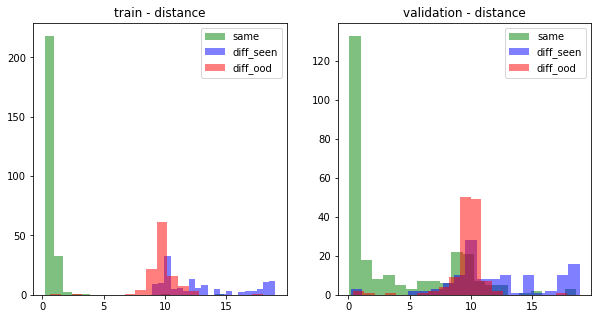


Epoch 1, Train loss 1.0040373722302545, Val loss 19.99515192132247
Val auroc diff 0.8455744160862543, Val auroc ood 0.636443755533878
Distance distribution of last training batch:
mean_same = 0.4964420795440674, mean_diff_seen = 12.724932670593262, mean_diff_ood = 10.338112831115723
Distance distribution of last validation batch:
mean_same = 4.248490333557129, mean_diff_seen = 11.506080627441406, mean_diff_ood = 8.896478652954102
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6658627920944584

Epoch 2, Train loss 0.7099577136260947, Val loss 18.852408409118652
Val auroc diff 0.8974350455699355, Val auroc ood 0.7739398132641334
Distance distribution of last training batch:
mean_same = 0.527197003364563, mean_diff_seen = 11.430097579956055, mean_diff_ood = 10.35106372833252
Distance distribution of last validation batch:
mean_same = 4.152867317199707, mean_diff_seen = 10.575133323669434, mean_diff_ood = 10.283364295959473

Epoch 3, Train loss 0.6040101599754747, Val loss 18.1

Epoch,9
Train Loss,0.59803
Val Loss,17.57326
Val auroc diff,0.83126
Val auroc ood,0.60749
Train mean distance (same),0.39943
Train mean distance (diff_seen),10.14008
Train mean distance (diff_ood),11.17276
Val mean distance (same),3.45573
Val mean distance (diff_seen),9.45951
Val mean distance (diff_ood),8.64132


Epoch,▁▂▃▃▄▅▆▆▇█
Train Loss,█▃▂▁▁▁▁▁▁▁
Val Loss,█▇▅▃▁▂▃▂▂▂
Val auroc diff,▅▃█▃▇▅▁▆▂▁
Val auroc ood,▃▂█▂▆▅▂▆▂▁
Train mean distance (same),█▅▅▂▁▁▃▂▅▃
Train mean distance (diff_seen),█▇▄▄▃▂▂▂▁▁
Train mean distance (diff_ood),▁▄▄▃▆▅██▅█
Val mean distance (same),▄█▇▅█▁▅▂▁▂
Val mean distance (diff_seen),█▆▄▂▂▁▁▁▂▁
Val mean distance (diff_ood),▅▂█▁▅▃▁▄▃▁


Distance distribution of last training batch:
mean_same = 0.39942634105682373, mean_diff_seen = 10.140077590942383, mean_diff_ood = 11.172758102416992
Distance distribution of last validation batch:
mean_same = 3.455726146697998, mean_diff_seen = 9.45950984954834, mean_diff_ood = 8.641321182250977


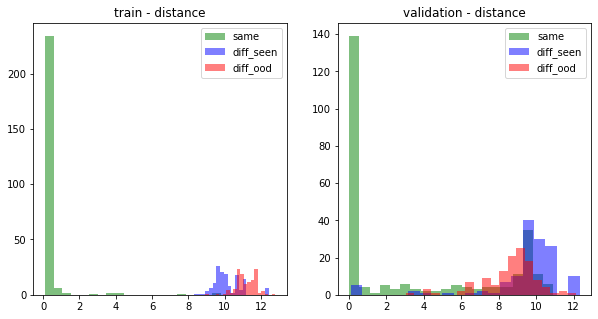

Distance distribution of last training batch:
mean_same = 0.39942634105682373, mean_diff_seen = 10.140077590942383, mean_diff_ood = 11.172758102416992
Distance distribution of last validation batch:
mean_same = 3.455726146697998, mean_diff_seen = 9.45950984954834, mean_diff_ood = 8.641321182250977


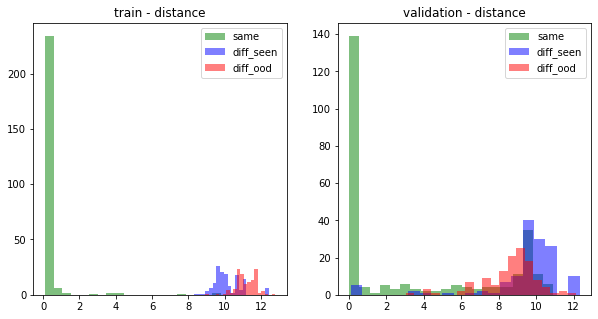

auroc: 0.844541084916457


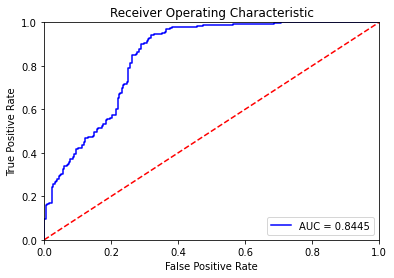

auroc: 0.6063283380186426


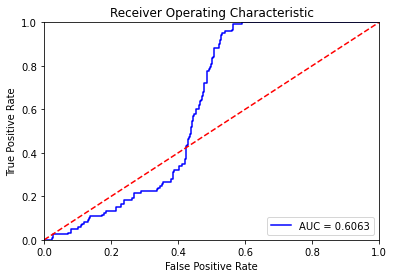

In [11]:
# further train the best siamese_without_oe model for 10 epochs with SVHN OE
model = train()
torch.save(model.state_dict(), "./stat_dict/siamese_with_oe_continue_0726.pth")


Epoch 0, Train loss 4.881956118898294, Val loss 36.20201813547235
Val auroc diff 0.912280274622168, Val auroc ood 0.6734653914986336
Distance distribution of last training batch:
mean_same = 0.9407086968421936, mean_diff_seen = 19.370155334472656, mean_diff_ood = 17.64578628540039
Distance distribution of last validation batch:
mean_same = 4.596897125244141, mean_diff_seen = 17.65746307373047, mean_diff_ood = 15.970131874084473


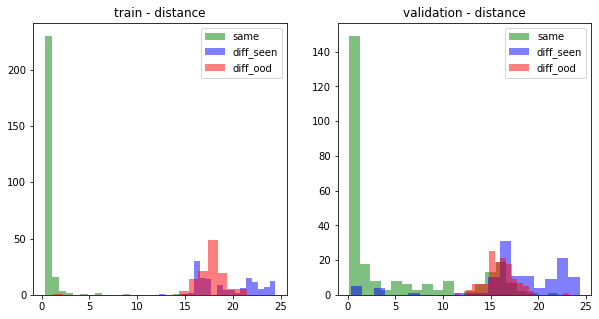


Epoch 1, Train loss 1.37279602700902, Val loss 36.26434797989695
Val auroc diff 0.9061127393752594, Val auroc ood 0.6710517723271426
Distance distribution of last training batch:
mean_same = 0.883899986743927, mean_diff_seen = 18.44905662536621, mean_diff_ood = 18.37731170654297
Distance distribution of last validation batch:
mean_same = 4.709951400756836, mean_diff_seen = 16.605649948120117, mean_diff_ood = 15.783136367797852
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6734653914986336

Epoch 2, Train loss 1.2308271057212476, Val loss 36.15088392558851
Val auroc diff 0.9108301631157821, Val auroc ood 0.6834173520678195
Distance distribution of last training batch:
mean_same = 0.6824373006820679, mean_diff_seen = 18.13785743713379, mean_diff_ood = 17.88931655883789
Distance distribution of last validation batch:
mean_same = 5.079707145690918, mean_diff_seen = 17.18552589416504, mean_diff_ood = 15.933321952819824

Epoch 3, Train loss 1.1147461613428962, Val loss 35.884425

Epoch,9
Train Loss,0.99491
Val Loss,35.54302
Val auroc diff,0.92197
Val auroc ood,0.74126
Train mean distance (same),0.63778
Train mean distance (diff_seen),17.65015
Train mean distance (diff_ood),18.96871
Val mean distance (same),4.75661
Val mean distance (diff_seen),16.81652
Val mean distance (diff_ood),16.52896


Epoch,▁▂▃▃▄▅▆▆▇█
Train Loss,█▂▁▁▂▂▂▂▂▁
Val Loss,███▇▁▂▃▄▄▅
Val auroc diff,▃▁▃▆▃▆▆██▆
Val auroc ood,▁▁▂▅▂▅▆██▆
Train mean distance (same),▇▆▂▆▁█▂▅▅▂
Train mean distance (diff_seen),█▅▅▃▂▂▁▃▂▃
Train mean distance (diff_ood),▁▅▂▄▅▅▂█▆█
Val mean distance (same),▅▆▇▃█▁▄▃▅▆
Val mean distance (diff_seen),█▄▆▅▁▄▁▁▃▄
Val mean distance (diff_ood),▅▄▅█▁▅▇█▇▇


Distance distribution of last training batch:
mean_same = 0.63777756690979, mean_diff_seen = 17.65015411376953, mean_diff_ood = 18.968708038330078
Distance distribution of last validation batch:
mean_same = 4.7566118240356445, mean_diff_seen = 16.816524505615234, mean_diff_ood = 16.52896499633789


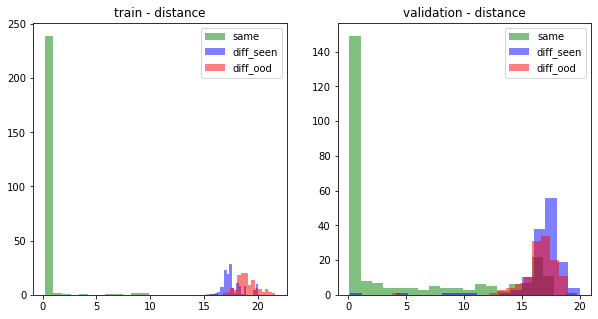

Distance distribution of last training batch:
mean_same = 0.63777756690979, mean_diff_seen = 17.65015411376953, mean_diff_ood = 18.968708038330078
Distance distribution of last validation batch:
mean_same = 4.7566118240356445, mean_diff_seen = 16.816524505615234, mean_diff_ood = 16.52896499633789


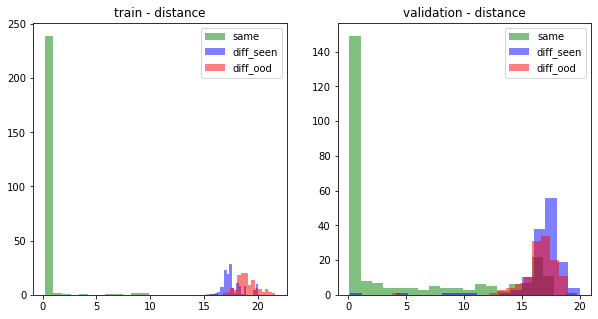

auroc: 0.9385061417563134


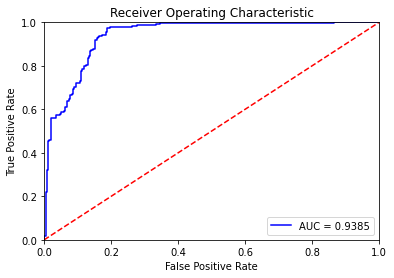

auroc: 0.7391092980490795


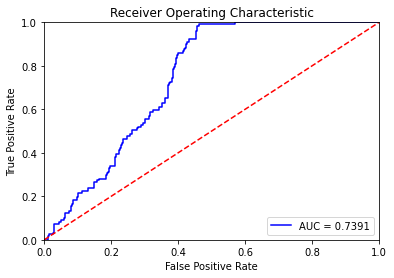

In [9]:
### class rotation - SVHN class 5-9 as OE
model = train()
torch.save(model.state_dict(), "./stat_dict/siamese_with_oe_continue_rotation.pth")